# WZK - Zadanie 3

Autor: Dariusz Max Adamski - nr indeksu 136674

---

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import cm
from random import getrandbits
from time import time
from Crypto.Cipher import AES

sns.set_style('darkgrid')
plt.rc('figure', figsize=(10, 6), dpi=200)

pad = lambda x: x + b'\0' * (AES.block_size - len(x) % AES.block_size)
strip = lambda x: x.rstrip(b'\0')
hexdump = lambda x: ' '.join(f'{b:02X}' for b in x)
flatten = lambda xss: [x for xs in xss for x in xs]

def cipher_params(cipher, mode):
    if mode in [AES.MODE_CBC, AES.MODE_OFB, AES.MODE_CFB]: return dict(iv=cipher.iv)
    if mode in [AES.MODE_CTR]: return dict(nonce=cipher.nonce)
    return {}

In [12]:
modenames = 'ECB CBC OFB CTR CFB'.split()
files = 'paper.pdf weka.zip movie.mp4'.split()
sizes = [0.495, 135.53, 1560.41]
modes = [AES.MODE_ECB, AES.MODE_CBC, AES.MODE_OFB, AES.MODE_CTR, AES.MODE_CFB]
key = getrandbits(16*8).to_bytes(16, byteorder='little')

decr_time = pd.DataFrame(index=files, columns=modenames)
encr_time = pd.DataFrame(index=files, columns=modenames)

print('key =', hexdump(key))

key = 2E D9 69 47 32 0B F1 15 AB 27 5E C8 6F 8D 11 BA


## Analiza czasu szyfrowania

In [13]:
for file in files:
    with open(file, 'rb') as f:
        original = f.read()
        
    for mode, name in zip(modes, modenames):
        c1 = AES.new(key, mode)
        t1 = time()
        encrypted = c1.encrypt(pad(original))
        t1 = time() - t1
        
        c2 = AES.new(key, mode, **cipher_params(c1, mode))
        t2 = time()
        decrypted = c2.decrypt(encrypted)
        t2 = time() - t2
        
        decrypted = strip(decrypted)
        encr_time.loc[file, name] = t1
        decr_time.loc[file, name] = t2

In [41]:
def join_tables(a, b):
    df = pd.concat([a, b], axis=1)
    df.columns = [x+' - encrypt' for x in modenames] + [x+' - decrypt' for x in modenames]
    return df[flatten([(x+' - encrypt', x+' - decrypt') for x in modenames])]

time_all = join_tables(encr_time, decr_time)
time_all

,ECB - encrypt,ECB - decrypt,CBC - encrypt,CBC - decrypt,OFB - encrypt,OFB - decrypt,CTR - encrypt,CTR - decrypt,CFB - encrypt,CFB - decrypt
paper.pdf,0.000256062,0.000112295,0.000967979,0.00083375,0.000946999,0.000864983,0.000538349,0.000500679,0.0120728,0.0115998
weka.zip,0.126153,0.0846431,0.360786,0.313712,0.342494,0.302751,0.244514,0.204302,3.41366,3.26048
movie.mp4,1.38034,0.935417,4.00373,3.41701,3.84122,3.43487,2.69847,2.24795,39.199,37.325


In [39]:
decr_speed / encr_speed

,ECB,CBC,OFB,CTR,CFB
paper.pdf,2.28025,1.161,1.09482,1.07524,1.04078
weka.zip,1.4904,1.15005,1.13128,1.19683,1.04698
movie.mp4,1.47564,1.1717,1.1183,1.20041,1.05021


In [42]:
speed_all = join_tables((sizes / encr_time.T).T, (sizes / decr_time.T).T)
speed_all

,ECB - encrypt,ECB - decrypt,CBC - encrypt,CBC - decrypt,OFB - encrypt,OFB - decrypt,CTR - encrypt,CTR - decrypt,CFB - encrypt,CFB - decrypt
paper.pdf,1933.13,4408.03,511.375,593.703,522.704,572.266,919.478,988.657,41.0013,42.6732
weka.zip,1074.33,1601.19,375.652,432.021,395.715,447.662,554.282,663.382,39.7023,41.5675
movie.mp4,1130.45,1668.14,389.739,456.659,406.228,454.285,578.257,694.147,39.8073,41.806


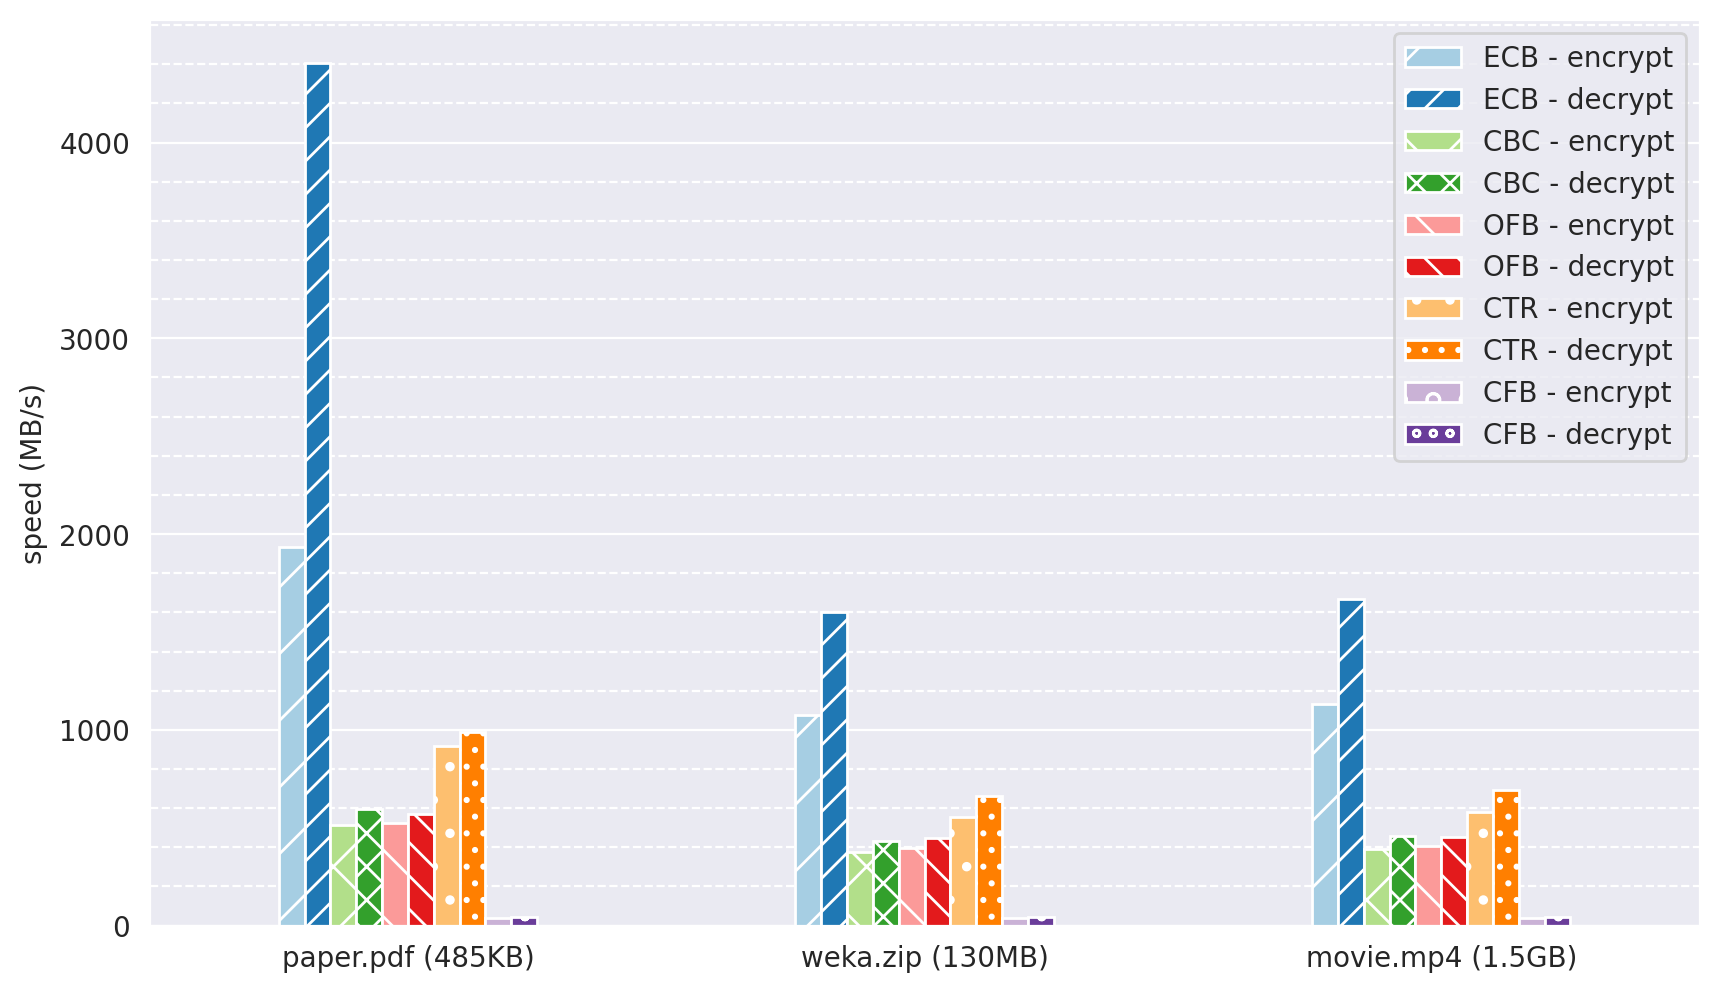

In [43]:
def plot_results(df):
    cmap = np.array(cm.get_cmap('Paired', 12)(np.arange(10)))
    cmap = np.vstack([cmap, cmap, cmap])
    labels = ['paper.pdf (485KB)', 'weka.zip (130MB)', 'movie.mp4 (1.5GB)']
    fig, ax1 = plt.subplots(ncols=1)
    hatch = ['/', '//', 'x', 'xx', '\\', '\\\\', '.', '..', 'o', 'oo', 'O']
    hatch = flatten(zip(hatch, hatch, hatch))
    bar = df.plot(kind='bar', color=cmap, hatch=hatch, ax=ax1)
    for i, b in enumerate(bar.patches):
        b.set_hatch(hatch[i])
    ax1.set_xticklabels(labels, rotation=0)
    ax1.minorticks_on()
    ax1.grid(True, which='minor', ls='--')
    ax1.grid(False, axis='x', which='both')
    ax1.legend()
    
plot_results(speed_all)
plt.ylabel('speed (MB/s)')
plt.show()

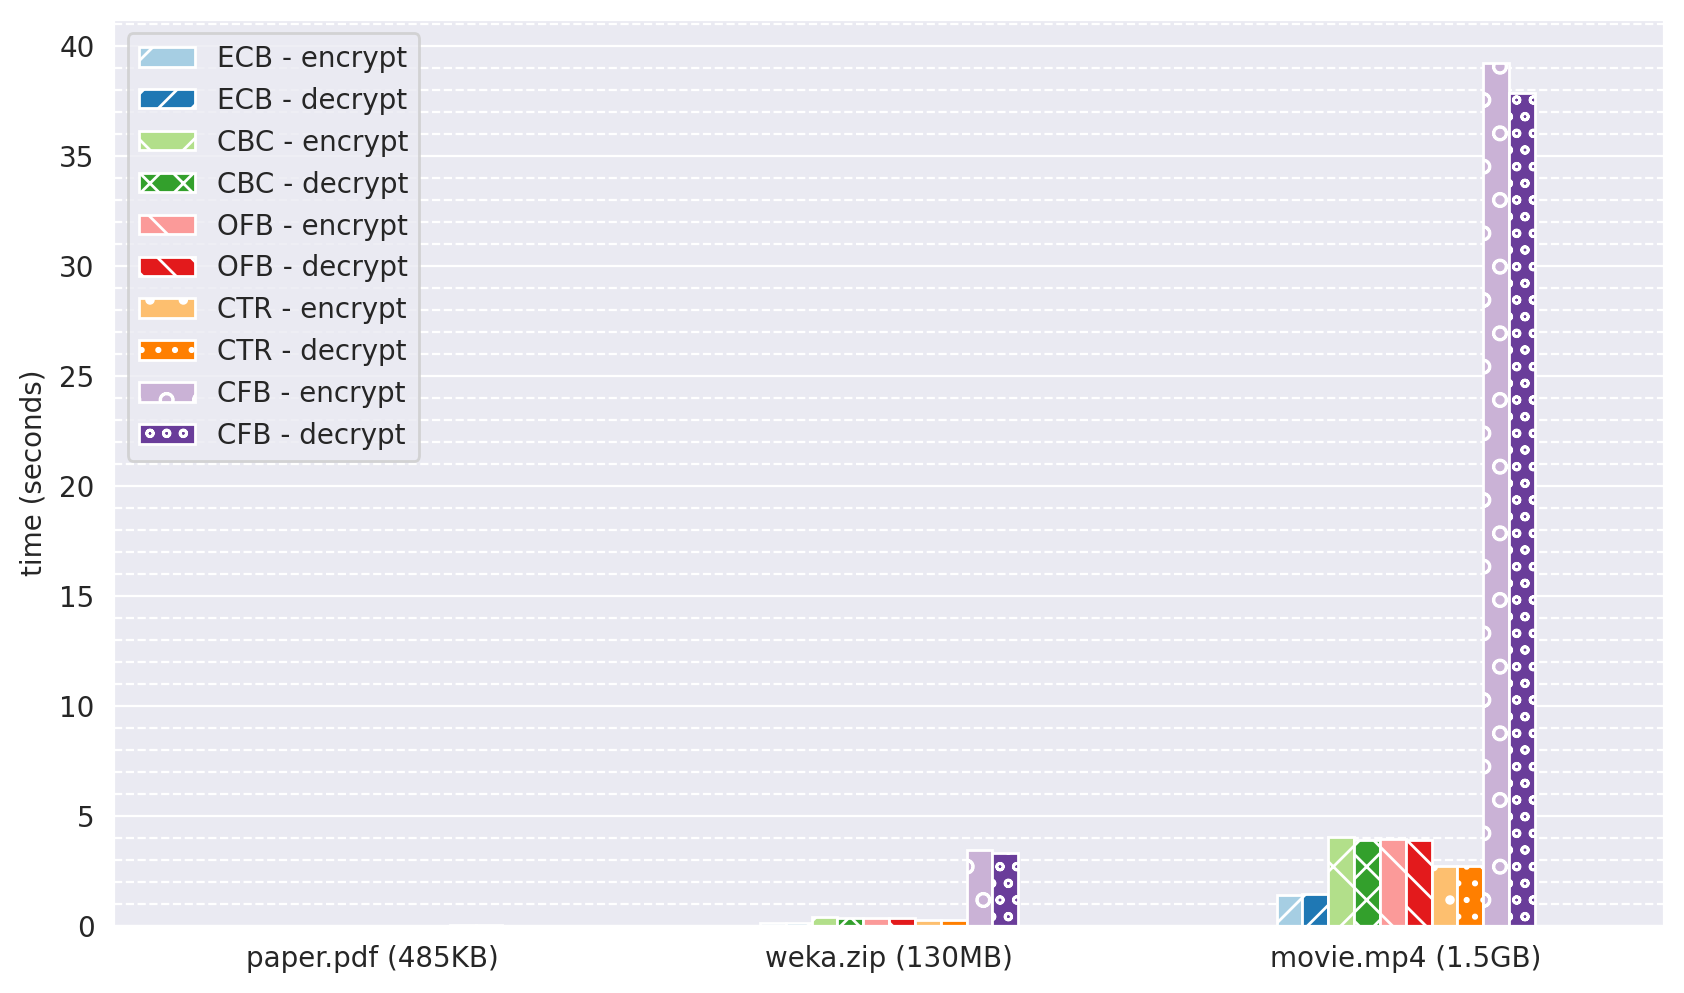

In [7]:
plot_results(time_all)
plt.ylabel('time (seconds)')
plt.show()

## Analiza propagacji błędów

In [61]:
with open('test.txt', 'rb') as f:
    test = f.read()
    
print('--- ORIGINAL ---')
print(test)
print()

for mode, name in zip(modes, modenames):
    c1 = AES.new(key, mode)
    encrypted = c1.encrypt(pad(test))
    
    encrypted = bytearray(encrypted)
    encrypted[120] = 0

    c2 = AES.new(key, mode, **cipher_params(c1, mode))
    decrypted = strip(c2.decrypt(encrypted))
    print('---', name, '---')
    print(decrypted)
    print()

--- ORIGINAL ---
b'Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, "and what is the use of a book," thought Alice "without pictures or conversations?"\n'

--- ECB ---
b'Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or\xf3D\xe9\x95\x9a\x0c4U\x18\xb5C\x18\x1a\xedrUeeped into the book her sister was reading, but it had no pictures or conversations in it, "and what is the use of a book," thought Alice "without pictures or conversations?"\n'

--- CBC ---
b'Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or\x1c\xfa\x10\x8f\xechQ\xc5\x94\xd1\xab\x0btq\xba\xd7eeped in~o the book her sister was reading, but it had no pictures or conversations in it, "and what is the use of a book," thought Alice "withou